# DATA620: Project 3 - Gender Identification

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

Your project should be submitted (as an Jupyter Notebook via GitHub). The team members should all submit a link to the same repository. If any of you don't submit the link to GitHub, I will assume you didn't collaborate.
Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

### Load Required Packages

In [1]:
import nltk
from nltk.corpus import names
from nltk.classify import apply_features
from nltk.probability import FreqDist
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

random.seed(303)

<br>

### Model Base Class
This is a Generic class with base model and boiler plate analysis code. It is used to simplify the analysis for each subsequent model.

In [2]:

# generic class with base model
class GenderAnalysis():
    
    # set corpus and training datasets
    def __init__(self):
       
        # Import and Lable Names
        self._names_lst = ([(name, 'male') for name in names.words('male.txt')] +
                [(name, 'female') for name in names.words('female.txt')])
        random.shuffle(self._names_lst)

        # Split Corpus
        self._train_names = self._names_lst[1000:]
        self._devtest_names = self._names_lst[500:1000]
        self._test_names = self._names_lst[:500]
    
        # apply features training, devtest and test corpus
        self._train_set = apply_features(self.gender_features, self._train_names)
        self._devtest_set = apply_features(self.gender_features, self._devtest_names)
        self._test_set = apply_features(self.gender_features, self._test_names)
        
        self._classifier = None
        
    
    # generate features
    def gender_features(self, name):
        features = {}
        features["suffix1"] = name[-1].lower()
        return features
    
    
    # get features dataframe 
    def get_names_features(self):
        # analyze data
        df = pd.DataFrame(self._names_lst, columns=['name','gender'])
        return df
    
    
    # get names that can be both male and female
    def ambiguous_names(self):
        # analyze data
        df = pd.DataFrame(self._names_lst, columns=['name','gender'])
        df2 = df.groupby(['name'])['name'].count().reset_index(name='count').sort_values(
            ['count'], ascending=False)
        df2 = df2[df2['count']>1]
        name_df = pd.merge(df,df2,how="inner", on=["name"])
        
        #name_df = name_df.drop('count', 1)
        name_df = name_df[['name']]
        name_df = name_df.groupby('name').first().reset_index()
        
        return name_df
    
    
    # train the model
    def train(self):
        self._classifier = nltk.NaiveBayesClassifier.train(self._train_set)
        
        
    # return the accuracy of the dev test
    def get_devtest_accuracy(self):     
        return nltk.classify.accuracy(self._classifier, self._devtest_set)
        

    # return the features with the biggest impact
    def show_inform_feature(self, n=20):
        self._classifier.show_most_informative_features(n)
        
    
    # return a dataframe with the errors
    def get_errors(self):
        errors = []
        for (name, tag) in self._devtest_names:
            guess = self._classifier.classify(self.gender_features(name))
            if guess != tag:
                errors.append((tag, guess, name))                
          
        errors_df = pd.DataFrame(errors, columns=['tag', 'guess', 'name'])
        return errors_df
    
    
    # print the model errors
    def print_Errors(self):
        for (tag, guess, name) in sorted(errors):
            print ('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

     
    # print the errors that are driven by Unisex names
    def get_ambiguous_errors(self):
        df1 = self.ambiguous_names()
        df2 = self.get_errors()
        error_df = pd.merge(df1,df2,how="inner", on=["name"])
        return error_df
    
    
    # determint the accuracy of the model using test data
    def get_test_accuracy(self):
        return nltk.classify.accuracy(self._classifier, self._test_set)
    

<br>

### Model Sub-classes
Each Model class inherits from the GenderAnalusis base class. The key difference between each subclass is the implimention of the gender_features().

In [3]:
# Uses the last 2 letters as features 
class GenderAnalysis2(GenderAnalysis):
    
    def gender_features(self, name):
        features = {}
        features["suffix1"] = name[-1].lower()
        features["suffix2"] = name[-2].lower()

        return features

    
# Use the last 2 letter and the first letter as features
class GenderAnalysis3(GenderAnalysis):
    
    def gender_features(self, name):
        features = {}
        features["firstletter"] = name[0].lower()
        features["suffix1"] = name[-1].lower()
        features["suffix2"] = name[-2].lower()

        return features
    

# Add the vowels as first and last charater and vowel count 
class GenderAnalysis4(GenderAnalysis):
    
    
    def gender_features2(self, name):
        features = {}
        features["length"] = len(name)
        features["firstLetter"] = name[0].lower()
        features["lastLetter"] = name[-1].lower()
        features["firstVowel"] = features['firstLetter'] in 'aeiouy'
        features["lastVowel"] = features['lastLetter'] in 'aeiouy'

        # Gets num of vowels
        count = 0
        vowel = set("aeiouAEIOU")

        for i in name:
            if i in vowel:
                count = count + 1

        features["numVowels"] = count
        features["suffix2"] = name[-2:].lower()
        features["suffix3"] = name[-3:].lower()

        return features

<br>

### Analysis of Names Corpus
The corpus includes 365 Unisex names that have both male and female records. 

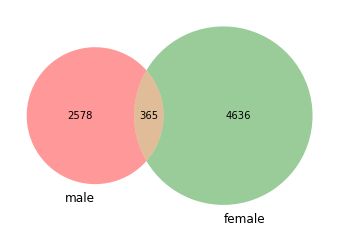

In [4]:
ga1 = GenderAnalysis()

# Use the venn2 function
df = ga1.get_names_features()
s1 = set(df[df['gender'] == 'male']['name'])
s2 = set(df[df['gender'] == 'female']['name'])
venn2([s1, s2], set_labels = ('male', 'female'))
plt.show()

This Venn diagram captures that overlap of unisex names between the male and female populations. Interestingly enough there are many more female names in the corpus than male names. 

<br>
### FuCorpus Exploration

In [5]:
# explore data further
df['length'] = df['name'].str.len()
df['last_letter'] = df['name'].str[-1]
df['first_letter'] = df['name'].str[0]

df['vowels'] = df['name'].str.replace(r'[^aeiou]', '')
df['vowel_last_letter'] = df['last_letter'].isin([*'aeiouy'])
df['vowel_first_letter'] = df['first_letter'].isin([*'AEIOUY'])

df['consonants'] = df['name'].str.replace(r'[aeiou]', '')
df['consonant_last_letter'] = df['last_letter'].isin([*'qwrtplkjhgfdszxcvbnm'])
df['consonant_first_letter'] = df['first_letter'].isin([*'QWRTPLKJHGFDSZXCVBNM'])

df['num_vowels'] = df['vowels'].str.len()
df['num_consonants'] = df['consonants'].str.len()

df.head()

/var/folders/23/9pp6ldg14w34nlfjzv4krtc80000gn/T/ipykernel_34359/1197325758.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['vowels'] = df['name'].str.replace(r'[^aeiou]', '')
/var/folders/23/9pp6ldg14w34nlfjzv4krtc80000gn/T/ipykernel_34359/1197325758.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['consonants'] = df['name'].str.replace(r'[aeiou]', '')


,name,gender,length,last_letter,first_letter,vowels,vowel_last_letter,vowel_first_letter,consonants,consonant_last_letter,consonant_first_letter,num_vowels,num_consonants
0,Aurilia,female,7,a,A,uiia,True,True,Arl,False,False,4,3
1,Linzy,female,5,y,L,i,True,False,Lnzy,False,True,1,4
2,Alfreda,female,7,a,A,ea,True,True,Alfrd,False,False,2,5
3,Paulita,female,7,a,P,auia,True,False,Plt,False,True,4,3
4,Chrissy,male,7,y,C,i,True,False,Chrssy,False,True,1,6


In [6]:
df.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,consonant_last_letter,consonant_first_letter,num_vowels,num_consonants
gender,,,,,,,
female,6.113777,0.804239,0.174965,0.195561,0.825035,2.475705,3.638072
male,5.895345,0.358818,0.158682,0.641182,0.841318,2.039076,3.856269


Notable differences between groups in the corpus:
* Female names tend to be longer
* Female names are much more likely to contain a vowel as the last letter
* Female names are slightly more likely to have a vowel as a first letter
* Males are much more likely to have a consonant for a last letter
* Both groups are almost equally likely to have a consonant as a first letter
* Females have more vowels on average
* Males have more consonants on average

This information provides us with a strong baseline for features to use in our gender name classifier.

In [7]:
print('Size Train Set',len(ga1._train_names))
print('Size Development Set',len(ga1._devtest_names))
print('Size Test Set',len(ga1._test_names))



Size Train Set 6944
Size Development Set 500
Size Test Set 500


<br>

### Model 1
This is a simple model the looks at the last character of a name to determine the associated gender. This model has a 76% accuracy if we use 303 as the seed. We can also count the number of errors that are driven by unisex names. With Model 1 there are 16 errors that can be attributed to unisex names.

In [19]:
ga1.train()
print('devtest accuracy:', ga1.get_devtest_accuracy())
print('ambiguous errors:',len(ga1.get_ambiguous_errors()))
e_df = ga1.get_errors()
e_df

devtest accuracy: 0.76
ambiguous errors: 16


,tag,guess,name
0,male,female,Herculie
1,female,male,Carrol
2,female,male,Easter
3,female,male,Joycelin
4,female,male,Carlynn
...,...,...,...
115,male,female,Perry
116,female,male,Isabel
117,female,male,Mirabel
118,female,male,Wren


In [9]:
ga1.show_inform_feature()

Most Informative Features
                 suffix1 = 'a'            female : male   =     37.2 : 1.0
                 suffix1 = 'k'              male : female =     26.0 : 1.0
                 suffix1 = 'f'              male : female =     23.2 : 1.0
                 suffix1 = 'p'              male : female =     11.9 : 1.0
                 suffix1 = 'd'              male : female =      9.9 : 1.0
                 suffix1 = 'v'              male : female =      9.2 : 1.0
                 suffix1 = 'm'              male : female =      8.8 : 1.0
                 suffix1 = 'o'              male : female =      7.8 : 1.0
                 suffix1 = 'r'              male : female =      7.6 : 1.0
                 suffix1 = 'w'              male : female =      5.4 : 1.0
                 suffix1 = 'b'              male : female =      4.8 : 1.0
                 suffix1 = 'z'              male : female =      4.6 : 1.0
                 suffix1 = 'g'              male : female =      4.5 : 1.0

### Feature 2

In [10]:
ga2 = GenderAnalysis2()
ga2.train()
print(ga2.get_devtest_accuracy())
e_df = ga2.get_errors()
e_df

0.752


,tag,guess,name
0,male,female,Patrice
1,female,male,Marcy
2,female,male,Margalit
3,male,female,Emery
4,female,male,Margot
...,...,...,...
119,male,female,Ike
120,male,female,Hamish
121,male,female,Fonsie
122,male,female,Herbie


In [11]:
ga2.show_inform_feature()

Most Informative Features
                 suffix1 = 'a'            female : male   =     38.6 : 1.0
                 suffix1 = 'k'              male : female =     31.8 : 1.0
                 suffix1 = 'f'              male : female =     16.2 : 1.0
                 suffix1 = 'p'              male : female =     11.4 : 1.0
                 suffix1 = 'v'              male : female =     10.0 : 1.0
                 suffix1 = 'd'              male : female =      9.3 : 1.0
                 suffix1 = 'o'              male : female =      8.4 : 1.0
                 suffix1 = 'm'              male : female =      8.0 : 1.0
                 suffix2 = 'o'              male : female =      7.5 : 1.0
                 suffix1 = 'r'              male : female =      6.6 : 1.0
                 suffix2 = 'u'              male : female =      6.1 : 1.0
                 suffix1 = 'g'              male : female =      5.8 : 1.0
                 suffix1 = 'w'              male : female =      4.2 : 1.0

### Feature 3

In [12]:
ga3 = GenderAnalysis3()
ga3.train()
print(ga3.get_devtest_accuracy())
e_df = ga3.get_errors()
e_df

0.778


,tag,guess,name
0,female,male,Murial
1,male,female,Eliott
2,male,female,Mace
3,male,female,Jake
4,male,female,Andrea
...,...,...,...
106,female,male,Gretchen
107,female,male,Max
108,female,male,Clo
109,female,male,Rosario


In [13]:
ga3.show_inform_feature()

Most Informative Features
                 suffix1 = 'a'            female : male   =     34.5 : 1.0
                 suffix1 = 'k'              male : female =     28.8 : 1.0
                 suffix1 = 'f'              male : female =     14.6 : 1.0
                 suffix1 = 'm'              male : female =     10.6 : 1.0
                 suffix1 = 'v'              male : female =      9.8 : 1.0
                 suffix1 = 'd'              male : female =      9.6 : 1.0
                 suffix1 = 'o'              male : female =      9.3 : 1.0
                 suffix1 = 'p'              male : female =      9.2 : 1.0
                 suffix1 = 'r'              male : female =      7.7 : 1.0
                 suffix2 = 'o'              male : female =      7.5 : 1.0
                 suffix2 = 'u'              male : female =      6.9 : 1.0
                 suffix1 = 'g'              male : female =      5.6 : 1.0
                 suffix1 = 'b'              male : female =      5.3 : 1.0

### Feature 4

In [14]:
ga4 = GenderAnalysis4()
ga4.train()
print(ga4.get_devtest_accuracy())
e_df = ga4.get_errors()
e_df

0.786


,tag,guess,name
0,female,male,Eileen
1,female,male,Gabriel
2,male,female,Christy
3,male,female,Kelley
4,female,male,Laural
...,...,...,...
102,female,male,Jasmin
103,male,female,Tommy
104,male,female,Jeffrey
105,male,female,Ajay


In [15]:
ga4.show_inform_feature()

Most Informative Features
                 suffix1 = 'k'              male : female =     42.6 : 1.0
                 suffix1 = 'a'            female : male   =     33.3 : 1.0
                 suffix1 = 'f'              male : female =     19.9 : 1.0
                 suffix1 = 'p'              male : female =     10.6 : 1.0
                 suffix1 = 'v'              male : female =      9.2 : 1.0
                 suffix1 = 'd'              male : female =      8.9 : 1.0
                 suffix1 = 'o'              male : female =      8.2 : 1.0
                 suffix1 = 'm'              male : female =      7.8 : 1.0
                 suffix1 = 'r'              male : female =      6.8 : 1.0
                 suffix1 = 'b'              male : female =      4.8 : 1.0
                 suffix1 = 'w'              male : female =      4.8 : 1.0
                 suffix1 = 'z'              male : female =      4.6 : 1.0
                 suffix1 = 't'              male : female =      4.4 : 1.0

In [16]:
df1 = ga4.get_ambiguous_errors()
df1

,name,tag,guess
0,Abbey,male,female
1,Ajay,male,female
2,Brett,female,male
3,Christy,male,female
4,Donny,male,female
5,Freddy,male,female
6,Gabriel,female,male
7,Gale,male,female
8,Isa,male,female
9,Kelley,male,female


### Conclusion

In [17]:
result_lst = []
result_lst.append(['ga1',ga1.get_devtest_accuracy(),len(ga1.get_errors()),len(ga1.get_ambiguous_errors()),ga1.get_test_accuracy()])
result_lst.append(['ga2',ga2.get_devtest_accuracy(),len(ga2.get_errors()),len(ga2.get_ambiguous_errors()),ga2.get_test_accuracy()])
result_lst.append(['ga3',ga3.get_devtest_accuracy(),len(ga3.get_errors()),len(ga3.get_ambiguous_errors()),ga3.get_test_accuracy()])
result_lst.append(['ga4',ga4.get_devtest_accuracy(),len(ga4.get_errors()),len(ga4.get_ambiguous_errors()),ga4.get_test_accuracy()])

result_df = pd.DataFrame(result_lst, columns=['id','dt accuracy','num_error','num_ambiguous_errors','test_accuracy'])
result_df

,id,dt accuracy,num_error,num_ambiguous_errors,test_accuracy
0,ga1,0.760,120,16,0.764
1,ga2,0.752,124,24,0.804
2,ga3,0.778,111,23,0.798
3,ga4,0.786,107,16,0.772
